## Campos involucrados

- direccion
- idzona
- ciudad
- provincia
- lat
- lng

## Objetivos

- Normalizar (provincia, ciudad, dirección)
- Agregar información (geometry)
- Métodos para graficar (cantidad+densidad)
- Método para definir si x publicación está en una geometry

- Agregar información externa (distrito electoral, etc.)


In [253]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

In [254]:
#importo las funciones para levantar los dataframes
%run "../../utils/dataset_parsing.ipynb"
#importo las funciones para graficar
%run "../../utils/graphs.ipynb"

In [180]:
pais = geopandas.read_file("./MEX_adm/MEX_adm0.shp")
estados = geopandas.read_file("./MEX_adm/MEX_adm1.shp")
municipios = geopandas.read_file("./MEX_adm/MEX_adm2.shp")
ciudades = geopandas.read_file("./México_Centros_Urbanos/México_Centros_Urbanos.shp")
mexico_polygon = pais.iloc[0]["geometry"]

In [186]:
df = levantar_datos("../../"+DATASET_RELATIVE_PATH)
df["tiene_gps"] = ~ (df["lat"].isna() & df["lng"].isna())
crear_punto = lambda x: Point(x["lng"],x["lat"]) if x["tiene_gps"] else None
df["coord"] = df.apply(crear_punto, axis=1)

In [187]:
def esta_en_mexico(point: Point) -> bool:
    """ 
        Recibe un punto (lat,lng) y devuelve (muy aproximadamente) True si está dentro de Mexico, False si no.
        Hacerlo con ```df["coord"].map(lambda x: mexico_polygon.contains(x))``` sería muy lento.
    """
    MEX_MIN_LNG, MEX_MAX_LNG = (-120, -85)
    MEX_MIN_LAT, MEX_MAX_LAT = (14,33)
    return (MEX_MIN_LNG < point.x < MEX_MAX_LNG) and (MEX_MIN_LAT < point.y < MEX_MAX_LAT)

In [189]:
df["en_mexico"] = df.loc[df["tiene_gps"]]["coord"].map(esta_en_mexico)

In [191]:
df["en_mexico"].value_counts()

True     115871
False       641
Name: en_mexico, dtype: int64

In [192]:
geoDF = geopandas.GeoDataFrame(df.loc[df["tiene_gps"] & df["en_mexico"]], geometry="coord")

In [193]:
def dibujar_mexico(puntos):
    grafico = pais.plot(figsize=(18,9))
    estados.plot(ax=grafico, color="white")
#     municipios.plot(ax=grafico, color="white")
    # ciudades.plot(ax=grafico, color="yellow")
    puntos.plot(ax=grafico, color="green")

In [194]:
def fix_provincias(df, provincias) -> bool:
    # le cambio los nombres a las siguientes provincias, para que coincidan con mi info geografica 
    provincias_mapper = {
        "Baja California Norte": "Baja California",
        "Edo. de México": "México",
        "San luis Potosí": "San Luis Potosí"
    }
    df["estado"] = df["provincia"].map(lambda x: provincias_mapper.get(x, x))
    return set(validos["provincia"].dropna().unique()) == set(provincias["NAME_1"]) #verifico

In [195]:
fix_provincias(geoDF, estados)

NameError: name 'validos' is not defined

In [196]:
def buscar_provincia(punto: Point, provincias):
    """
        Devuelve en qué provincia de mexico se encuentra el punto.
    """
#     if not punto: return None
    for provincia, geometry in provincias[["NAME_1","geometry"]].values:
        if geometry.contains(punto): return provincia

# agrego las provincias faltantes
geoDF.loc[geoDF["estado"].isna(), "estado"] = geoDF.loc[geoDF["estado"].isna()]["coord"].map(lambda x: buscar_provincia(x, estados))

In [197]:
publicaciones_por_estado = geoDF.loc[~geoDF["estado"].isna()].groupby(["estado"]).agg({"estado":"count"})

In [198]:
def choropleth_estados(estados, serie, nombre, titulo=""):
    estados[nombre] = estados["NAME_1"].map(serie)
    plot = estados.plot(column=nombre, legend=True, figsize=(24,8))    
    plot.set_title(titulo)
    return plot

ImportError: The descartes package is required for plotting polygons in geopandas.

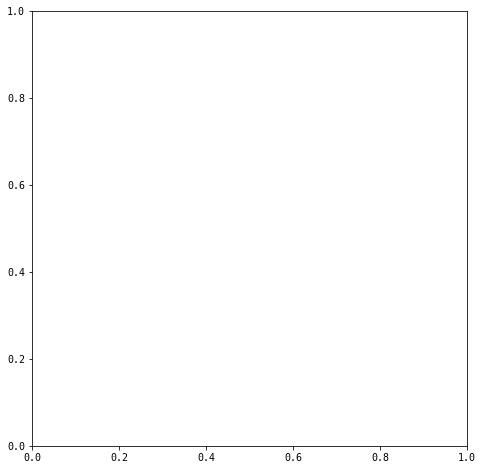

In [199]:
plot = choropleth_estados(estados, publicaciones_por_estado["estado"], "publicaciones", "Cantidad de publicaciones por estado")

# Presento un análisis del valor del metro cuadrado en relacion a la ciudad

### Primero realizo una limpieza de los datos. Selecciono las ciudades con mayor cantidad de publicaciones

In [200]:
df = levantar_datos("../../"+DATASET_RELATIVE_PATH)
mas_publicadas = df.groupby("ciudad").agg({"id":"count"})
mas_publicadas.columns = ["total"]
mas_publicadas=mas_publicadas.sort_values("total", ascending=False).head(100)
mas_publicadas.reset_index(inplace=True)
print(mas_publicadas)


             ciudad  total
0         Querétaro  12646
1     Benito Juárez  11014
2           Zapopan  10360
3   San Luis Potosí   7925
4            Mérida   7162
..              ...    ...
95         Tlaxcala    369
96           Colima    351
97          Cuautla    340
98   Valle de Bravo    329
99       Manzanillo    307

[100 rows x 2 columns]


In [201]:
lista_de_ciudades = mas_publicadas.ciudad
lista_de_ciudades = lista_de_ciudades.to_list()
lista_de_ciudades
df=df[df["ciudad"].isin(lista_de_ciudades)]
df


,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,mes,ano,dia
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,...,2015-08-23,False,False,False,False,False,2273000.0,8,2015,23
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,...,2013-06-28,False,False,False,True,True,3600000.0,6,2013,28
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,...,2015-10-17,False,False,False,False,False,1200000.0,10,2015,17
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,...,2016-06-07,False,False,False,False,False,1150000.0,6,2016,7
5,126147,departamento en venta taxqueña,"amplio departamento, estancia de sala y comedo...",Apartamento,Condominio Tlalpan 2B,Coyoacán,Distrito Federal,5.0,2.0,1.0,...,2014-03-18,False,False,False,False,True,1100000.0,3,2014,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239994,110268,hermosa casa en villa de los belenes,"<p>moderna casa 3 pisos, muro llor&oacute;n , ...",Casa,"MANUEL AMAYA,ENTRE SEBASTIAN ALLENDE Y AMADO A...",Zapopan,Jalisco,3.0,2.0,2.0,...,2013-07-31,False,False,False,False,False,1350000.0,7,2013,31
239996,259178,casa en condominio a 10 min. del centro de toluca,"casa con un jardin amplio, un cuarto de servic...",Casa,Filiberto Navas 325,Toluca,Edo. de México,0.0,3.0,3.0,...,2014-07-10,False,False,False,True,True,1940000.0,7,2014,10
239997,131932,nicolas san juan,"departamento con excelente ubicación, muy cerc...",Apartamento,Nicolas San Juan,Benito Juárez,Distrito Federal,20.0,2.0,1.0,...,2015-03-03,False,False,False,False,False,3400000.0,3,2015,3
239998,146867,casa sola. javier rojo gomez.,"casa sola, dividida en cuatro departamentos de...",Casa,Javier Rojo Gomez 120,Iztapalapa,Distrito Federal,20.0,4.0,0.0,...,2014-12-26,True,False,False,True,True,2890000.0,12,2014,26


In [202]:
#Realizo un calculo del promedio del valor del metro cuadrado por 
por_ciudad=df.groupby("ciudad").agg({"metrostotales":"sum"})
por_ciudad=por_ciudad.loc[por_ciudad.metrostotales != 0.0]
por_ciudad["precios"] = df.groupby("ciudad").agg({"precio":"sum"})
por_ciudad["valormetrocuadrado"] = por_ciudad["precios"] / por_ciudad["metrostotales"]
por_ciudad.reset_index(inplace=True)

### Limpio el dataset de valores nulos en metrostotales y/o precios

In [203]:
por_ciudad=por_ciudad.loc[(por_ciudad.metrostotales != 0.0)]
por_ciudad=por_ciudad.loc[(por_ciudad.precios != 0.0)]
por_ciudad

,ciudad,metrostotales,precios,valormetrocuadrado
0,Acapulco de Juárez,215112.0,6.345586e+09,29498.984273
1,Aguascalientes,234577.0,2.244675e+09,9569.032480
2,Alvarado,175231.0,2.334752e+09,13323.849690
3,Alvaro Obregón,787577.0,2.964769e+10,37644.178642
4,Apodaca,136968.0,1.069685e+09,7809.745656
...,...,...,...,...
95,Villahermosa,58798.0,1.025294e+09,17437.559220
96,Xalapa,196232.0,2.456251e+09,12517.077363
97,Xochimilco,198368.0,3.710373e+09,18704.493094
98,Yautepec,79426.0,1.034098e+09,13019.641050


# Busco las ciudades extremo, la más cara y la más barata

In [204]:
por_ciudad = por_ciudad.sort_values("valormetrocuadrado")
por_ciudad.reset_index(drop=True,inplace=True)
por_ciudad

,ciudad,metrostotales,precios,valormetrocuadrado
0,Juárez,134633.0,8.444726e+08,6272.404113
1,Tijuana,325388.0,2.083139e+09,6402.014048
2,Huehuetoca,27844.0,1.935853e+08,6952.495295
3,Soledad de Graciano Sánchez,40108.0,2.824004e+08,7040.999626
4,Durango,352948.0,2.502042e+09,7088.982139
...,...,...,...,...
95,Cuauhtémoc,526021.0,2.241594e+10,42614.154081
96,Cuajimalpa de Morelos,326328.0,1.426106e+10,43701.611967
97,San Pedro Garza García,211194.0,1.001757e+10,47433.020095
98,Valle de Bravo,27467.0,1.503251e+09,54729.340445


### Ahora armo un dataframe con las 20 ciudades más caras y las 20 más baratas.

In [205]:
top_20_ciudades_mas_caras = por_ciudad.tail(20)
top_20_ciudades_mas_caras.reset_index(drop=True, inplace=True)
top_20_ciudades_mas_caras

,ciudad,metrostotales,precios,valormetrocuadrado
0,Venustiano Carranza,146872.0,2.833401e+09,19291.636234
1,Gustavo A. Madero,401043.0,8.145237e+09,20310.135043
2,Lerma,52831.0,1.075411e+09,20355.681797
3,Iztacalco,126238.0,2.604569e+09,20632.212171
4,Azcapotzalco,183353.0,3.877933e+09,21150.092979
5,Naucalpan de Juárez,1251166.0,2.662000e+10,21276.155348
6,Santiago,62329.0,1.404003e+09,22525.680935
7,Atizapán de Zaragoza,827829.0,1.875306e+10,22653.303395
8,Tlalpan,758911.0,2.042320e+10,26911.197085
9,Coyoacán,661173.0,1.803330e+10,27274.706382


In [206]:
top_20_ciudades_mas_baratas = por_ciudad.head(20)
top_20_ciudades_mas_baratas.reset_index(inplace=True)
top_20_ciudades_mas_baratas

,index,ciudad,metrostotales,precios,valormetrocuadrado
0,0,Juárez,134633.0,8.444726e+08,6272.404113
1,1,Tijuana,325388.0,2.083139e+09,6402.014048
2,2,Huehuetoca,27844.0,1.935853e+08,6952.495295
3,3,Soledad de Graciano Sánchez,40108.0,2.824004e+08,7040.999626
4,4,Durango,352948.0,2.502042e+09,7088.982139
5,5,Torreón,280591.0,2.056099e+09,7327.745573
6,6,Los Cabos,104581.0,7.910483e+08,7563.976755
7,7,La Paz,179201.0,1.361818e+09,7599.389574
8,8,Apodaca,136968.0,1.069685e+09,7809.745656
9,9,Mineral de la Reforma,53248.0,4.282192e+08,8041.977145


In [233]:
ciudad_mas_barata = (top_20_ciudades_mas_baratas.loc[0,:].ciudad,top_20_ciudades_mas_baratas.loc[0,:].valormetrocuadrado)
print("Ciudad mas barata {}".format(ciudad_mas_barata))
ciudad_mas_cara = (top_20_ciudades_mas_caras.loc[0,:].ciudad,top_20_ciudades_mas_caras.loc[0,:].valormetrocuadrado)
print("Ciudad mas cara {}".format(ciudad_mas_cara))
amplitud = ciudad_mas_cara[1] - ciudad_mas_barata[1]
print("Amplitud de precio {}".format(amplitud))

Ciudad mas barata ('Juárez', 6272.404113404589)
Ciudad mas cara ('Venustiano Carranza', 19291.63623427202)
Amplitud de precio 13019.232120867431


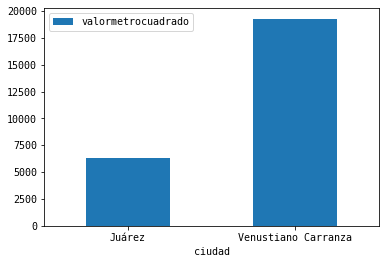

In [255]:
ciudades_punta= pd.DataFrame([ciudad_mas_barata, ciudad_mas_cara])
ciudades_punta.columns = ["ciudad","valormetrocuadrado"]
ciudades_punta = ciudades_punta.reset_index(drop=True)
ciudades_punta.reset_index(inplace=True)
#ciudades_punta.plot.bar(x='ciudad', y='valormetrocuadrado', rot=0)
bar_plot(ciudades_punta,x='ciudad', y='valormetrocuadrado')